# Discrete (orthogonal) wavelet transform (DWT)

Historically the continuous wavelet transform, which we studied up to this point, predated the discrete wavelet transform (**DWT**). While CWT is mainly useful for signal *analysis*, DWT and **multiresolution analysis** (**MRA**) - based upon DWT - is useful mainly for signal *processing* (reconstruction, synthesis).

In case of analysis of the function $f(t)$ with basis functions $\psi_{m,n}(t)$  ($m$: scale, $n$: shift)

$$f(t)=\sum\sum c_{mn} \psi_{mn}(t) $$

$$\psi_{mn}(t)=2^{-m/2} \psi(2^{-m}t-n) $$

there is a *complete orthonormal basis* $\psi_{m,n}(t)$ such that

$$c_{mn}=\int f(t)\psi_{m,n}(t) dt = \langle f, \psi_{m,n} \rangle.$$

### How to construct suitable basis functions $\psi_{m,n}$ ?

The answer is provided by the multiresolution analysis (MRA):

If the wavelet function $\psi_{m,n}(t)$ can be fit into an MRA, then its dyadic discretization ($a = 2^{-j}$, $b = 2^{-j} k$) leads to the discrete wavelet transform (DWT).

If there is no such MRA for the wavelet $\psi(t)$, then this discretization does not lend itself to a simple reconstruction.

MRA is in close connection with filter banks.

## Discrete Haar wavelet transform

The Haar filter

$$ \mathbf{h} = \left( \frac{\sqrt{2}}{2},\frac{\sqrt{2}}{2} \right)$$

$$ H(\omega) = \frac{\sqrt{2}}{2} + \frac{\sqrt{2}}{2} e^{i\omega}$$

is actually an orthogonal modification of the most simple convolution filter (which averages two subsequent values and is a lowpass filter). The original signal cannot be reconstructed from the filtered one. What is required for the filtering to be invertible?

Besides averages, *differences* of the subsequent values are necessary. Differencing is the following (orthogonal) convolution filtering:

$$ \mathbf{g} = \left( \frac{\sqrt{2}}{2},-\frac{\sqrt{2}}{2} \right)$$

This filter is *highpass*. Therefore filtering with the pair of filters $\mathbf{g}$, $\mathbf{h}$ is invertible. Inversion is redundant, that is every other item is unnecessary, because signal reconstruction is still possible.

The filters $\mathbf{g}$, $\mathbf{h}$ are called **Quadrature Mirror Filters** (**QMF**) and these define the **Haar wavelet transform**.

## Multiresolution analysis, MRA

A signal in $L^2(R)$ is successively approximated within a set of nested subspaces $V_j$. These subspaces are generated as shifted and scaled copies of one **scaling function** $\varphi(t)$.

## Approximation, compression

For typical signals the neighboring samples are strongly correlated.
In this case the wavelet coefficients of the highpass filtered signal (with filter $\mathbf{g}$) become small and most of them can safely be neglected.

An immediate application would be the solution of dense linear systems with wavelet preconditioning or the approximation of integral operators.

## Image compression
 
A typical application of DWT and MRA is image resolution and compression. Two wavelets will be used for this purpose and compared: Haar and Daubechies2 wavelets.

### Haar wavelets

Haar wavelet and scaling functions, named after Alfred Haar are very simple. Wavelet functions calculate the difference, whereas scaling functions the mean of two values.

Let us write Python functions for analysis and reconstruction.

In [1]:
## Haar wavelet transform
## v can be a vector or a matrix, in the latter case it is transformed row-wise
def haar1(v):
    n=v.shape[1]
    i=int(n)
    while i>1:
        av=(v[:,:i:2]+v[:,1:i:2])/2.0
        dv=v[:,:i:2]-av
        v[:,:i]=np.hstack((av,dv))
        i=i//2
    return v

## transform of rows and columns: 2D Haar WT
def haar2(X):
    a = np.copy(X)
    a = haar1(a).T
    return haar1(a).T


## inverse Haar wavelet transform
def invhaar1(v):
    n=v.shape[1]
    i=2
    while i<=n:
        av=np.copy(v[:,0:i//2])
        dv=np.copy(v[:,i//2:i])
        v[:,:i:2]=av+dv
        v[:,1:i:2]=av-dv
        i=2*i
    return v

def invhaar2(X):
    a = np.copy(X)
    a = invhaar1(a).T
    return invhaar1(a).T

Let us make first a plot of the Haar wavelet.

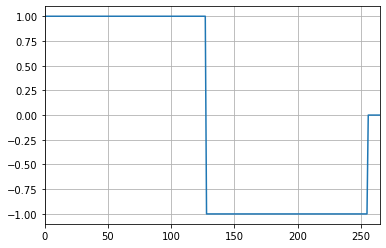

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
v=np.zeros((2,1024))
v[:,4]=1
iv=invhaar1(v)
plt.plot(iv[1,:])
plt.grid()
plt.xlim([0,265])
plt.ylim([-1.1,1.1])
plt.show()

Let us analyze the standard image processing Lena test picture. First it is read from file:

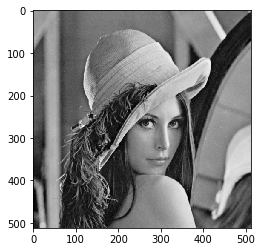

In [3]:
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img = mpimg.imread('lena.png')
l = rgb2gray(img)
plt.imshow(l, cmap = plt.get_cmap('gray'))
plt.show()

Analyze it with Haar DWT using the functions we have written, i.e. calculate the matrix of discrete wavelet coefficients and also make a color plot of it:

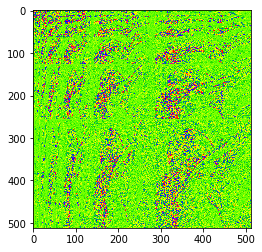

In [4]:
lh = haar2(l)
plt.imshow(lh, cmap = plt.get_cmap('prism'))
plt.show()

At the lower right corner of the array of wavelet decomposition the first detail signal, at the upper left pixel the last average signal is found. The latter is the global average of the analyzed signal (one number).

First we check recovery of the original image with the inverse transform.

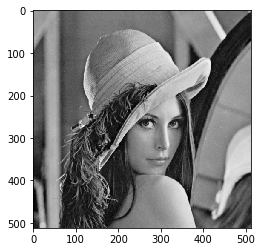

In [5]:
l2 = invhaar2(lh)
plt.imshow(l2, cmap = plt.get_cmap('gray'))
plt.show()

In [6]:
print("relative error: %5.3e" % (np.std(l-l2)/np.std(l)))

relative error: 1.902e-16


### Image compression with Haar wavelets

For image compression let us delete those elements of the transformed array that are below a specified threshold and check the relative amount of nonzero elements (in percent).

First check the relative amount of nonzero elements of the original array.

In [7]:
print("nonzero elements: %4.2f%%" % (
    100.0*np.count_nonzero(lh)/np.product(lh.shape)))

nonzero elements: 96.22%


Delete all the coefficients below the threshold in a new array:

In [9]:
lht = np.copy(lh)
thr = 0.03*np.amax(np.abs(lh)) # relative threshold
idx = np.abs(lht) < thr
lht[idx] = 0.0

print("nonzero elements: %4.2f%%" % (
    100.0*np.count_nonzero(lht)/np.product(lht.shape)))

nonzero elements: 8.25%


Make image reconstruction with compressed DWT transform:

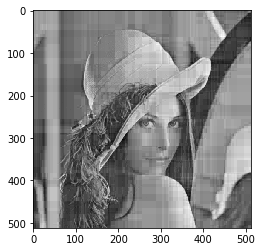

In [10]:
l2t = invhaar2(lht)
lhwt = np.copy(l2t) # save for later comparison
plt.imshow(l2t, cmap = plt.get_cmap('gray'))
plt.show()

Reconstruction looks quite good, because image details have been preserved, but a visually distracting "blocking" is seen, which is due to the shape of the Haar wavelet.

Much better quality can be achieved by using better mother wavelets. In the following the most simple of such wavelets, the Daubechies2 wavelet will be used.

## Daubechies wavelet

For the application of the wavelets named after the mathematician Ingrid Daubechies, let us first write Python functions for analysis and reconstruction.

In [11]:
## calculate filter coefficients, Daubechies2 wavelet
def daubechies2():
    c = (np.array([1,3,3,1])+np.sqrt(3.0)*np.array([1,1,-1,-1]))/4.0/np.sqrt(2.0)
    return c

## 1D Daubechies2 wavelet transform
def daub1(v):
    n=v.shape[1]
    i=int(n)
    c=daubechies2()
    while i>2:
        ov1=list(range(2,i,2))
        ov1.append(0)
        ev2=list(range(3,i,2))
        ev2.append(1)
        av=(c[0]*v[:,:i:2]+c[1]*v[:,1:i:2]+c[2]*v[:,ov1]+c[3]*v[:,ev2])
        dv=(c[3]*v[:,:i:2]-c[2]*v[:,1:i:2]+c[1]*v[:,ov1]-c[0]*v[:,ev2])
        v[:,:i]=np.hstack((av,dv))
        i=i//2
    return v

## 2D Daubechies2 wavelet transform
def daub2(X):
    a = np.copy(X)
    a = daub1(a).T
    return daub1(a).T

## inverse 1D Daubechies2 wavelet transform
def invdaub1(v):
    n=v.shape[1]
    i=4
    c=daubechies2()
    while i<=n:
        ivx=list(range(0,i//2-1))
        iv1=[i//2-1]
        iv1=iv1+ivx
        av=np.copy(v[:,0:i//2])
        dv=np.copy(v[:,i//2:i])
        v[:,:i:2]=c[0]*av+c[2]*av[:,iv1]+c[3]*dv+c[1]*dv[:,iv1]
        v[:,1:i:2]=c[1]*av+c[3]*av[:,iv1]-c[2]*dv-c[0]*dv[:,iv1]
        i=2*i
    return v

## inverse 2D Daubechies2 wavelet transform
def invdaub2(X):
    a = np.copy(X)
    a = invdaub1(a).T
    return invdaub1(a).T


Now let us see the Daubechies2 mother wavelet.

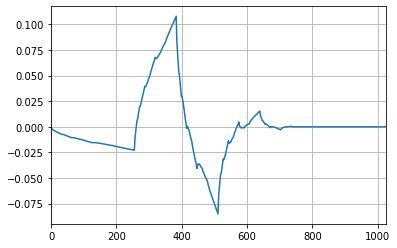

In [12]:
v=np.zeros((2,1024))
v[:,4]=1
iv=invdaub1(v)
plt.plot(iv[1,:])
plt.grid()
plt.xlim([0,1025])
plt.show()

Let us calculate Daubechies2 DWT analysis of our image with these functions and find the matrix of discrete wavelet coefficients.

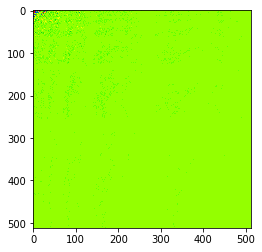

In [13]:
lh = daub2(l)
plt.imshow(lh, cmap = plt.get_cmap('prism'))
plt.show()

Not much can be seen. Try logarithmic normalization and take the absolute value.

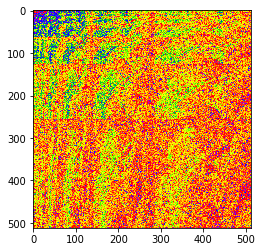

In [14]:
plt.imshow(np.log(abs(lh)), cmap = plt.get_cmap('prism'))
plt.show()

Let us check again the inverse transform.

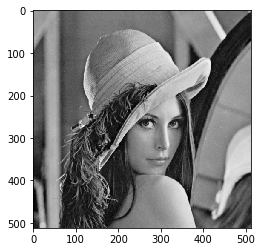

relative error: 4.229e-15


In [15]:
l2 = invdaub2(lh)
plt.imshow(l2, cmap = plt.get_cmap('gray'))
plt.show()
print("relative error: %5.3e" % (np.std(l-l2)/np.std(l)))

Delete all coefficients below some threshold in a new array and make reconstruction from this compressed array.

nonzero elements: 0.91%


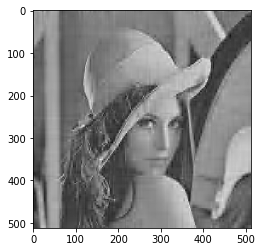

In [16]:
lht = np.copy(lh)
thr = 0.003*np.amax(np.abs(lh)) # relative threshold
idx = np.abs(lht) < thr
lht[idx] = 0.0
print("nonzero elements: %4.2f%%" % (
    100.0*np.count_nonzero(lht)/np.product(lht.shape)))

l2t = invdaub2(lht)
plt.imshow(l2t, cmap = plt.get_cmap('gray'))
plt.show()

Compression ratio is 1:100, but all the main image features are still there. Let us check image quality when we keep 8.2% nonzero elements and compare with our previous Haar wavelet decompression using the same 8.2% compression ratio.

nonzero elements: 8.20%


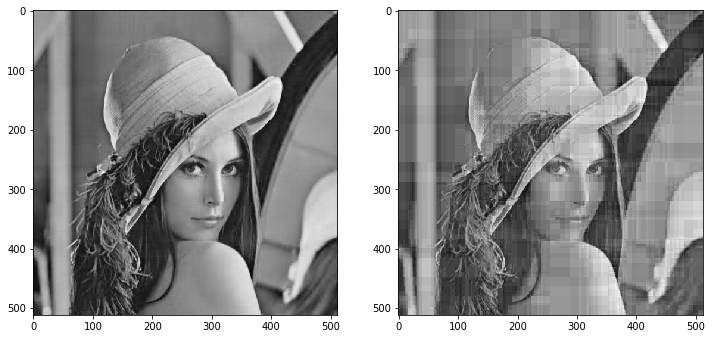

In [17]:
lht = np.copy(lh)
thr = 0.00044*np.amax(np.abs(lh)) # relative threshold
idx = np.abs(lht) < thr
lht[idx] = 0.0
print("nonzero elements: %4.2f%%" % (
    100.0*np.count_nonzero(lht)/np.product(lht.shape)))

l2t = invdaub2(lht)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(l2t, cmap = plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(lhwt, cmap = plt.get_cmap('gray'))
plt.show()

Now compression ratio is the same, however the result is much better with the Daubechies2 wavelet. This can be quantified with the [signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio_%28imaging%29).

In [18]:
def SNR(img,ref):
    return 20.0*np.log10(np.std(ref)/np.std(img-ref))

print("Haar  wavelet SNR: %6.2f dB" % SNR(lhwt,l))
print("Daub2 wavelet SNR: %6.2f dB" % SNR(l2t,l))

Haar  wavelet SNR:  11.94 dB
Daub2 wavelet SNR:  21.57 dB
